# Find convective layer depth

This script loads the runs, and attempts to find the best fit coefficient. 
To do this it is necessary to load $\langle w' b' \rangle$ (and maybe $\langle \hat{w}'\hat{b}'\rangle$).

Convective layer depth requires calculating the Ekman buoyancy flux, and H (the zero PV layer depth). 

Steps are then 
> 1) Find the depth where VBF = 0.

> 2) Minimize the residual of the (highly nonlinear) quartic equation...

In [478]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import h5py
from pylab import *
import scipy.integrate as integrate
#from cmocean import cm as cmo
import matplotlib.gridspec as gridspec
import matplotlib.ticker 
import scipy.stats as stats
import scipy.optimize as optimize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.signal import savgol_filter
from scipy.ndimage import uniform_filter
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 18})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

In [507]:
#%% Pick the filename and path
filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/snapshots_0p10.h5' #0.1 slope
#filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p05/snapshots/snapshots_1e-5_0p05.h5' #0.1 slope
#filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_5e-7_0p42/snapshots/snapshots_5e-7_0p42.h5' #0.1 slope
#filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p0225/snapshots/snapshots_1e-5_0p0225.h5' #0.1 slope
#filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p02/snapshots/snapshots_1e-5_0p02.h5' #Ruan case F
#filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-7_0p005/snapshots/snapshots_1e-7_0p005.h5' #Ruan case A

f = h5py.File(filename, 'r')

# Get the data
data = list(f['tasks'])

# Basic parameters
N = f['tasks']['N'][0,0,0] #Interior stratification (background)
tht = f['tasks']['tht'] # Slope angle


# Load variables in physical space
b = f['tasks']['b'] # Perturbation buoyancy
v = f['tasks']['v'] # Along-slope direction
vbfr = f['tasks']['VBFr']
vbfrot = f['tasks']['VBFrotated']
z = v.dims[2][0][:]
time = v.dims[0][0][:]
q = f['tasks']['PV']
qm = np.mean(q, axis=1)
vz = np.gradient(v, axis=-1)/np.gradient(z)
bz = np.gradient(b, axis=-1)/np.gradient(z)
# Calculate BEk
tauy = -1035*1e-4*np.mean(vz[:,:,0], axis=1) #Note that 1e-4 is the viscosity for the DNS
Bek = tauy/(1030*1e-4)*N**2*np.sin(tht[:,0,0])

# Calculate H
nt = Bek.shape[0]

toff = 12*2 # Starting timestep
Ho = 14 # Pick a starting depth (not necessarily starting at t=0, H=0)

Ent = 1.0 # Entrainment factor...
H2 = np.zeros((nt, )) 
for i in range(toff, nt):
    H2[i] = H2[i-1]+(2*Ent*-Bek[i]/(N**2))*(time[i]-time[i-1])
    
H = np.sqrt(Ho**2 + H2)

In [568]:
# Find zero crossing of vbf
vbfv = vbfr[:,0,:].copy() # choose variable (nt x nz)
#vbfv = uniform_filter(vbfv, [4, 30])
hn = np.zeros((nt,))
for i in range(0, nt):
    vsmooth = savgol_filter(vbfv[i,:], 25, 1)
    vsmooth = vbfv[i,:]
    inds = np.where(np.diff(np.sign(vsmooth)) <0)[0]
    #check vertical integral to inds

    if inds.size > 0:
        test = np.trapz(vsmooth[0:inds[0]], x=z[0:inds[0]])
        if test>0:
            hn[i] = z[inds[0]]
#hn[hn>H] = 0

/usr/local/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [481]:
vbfv.shape

(480, 256)

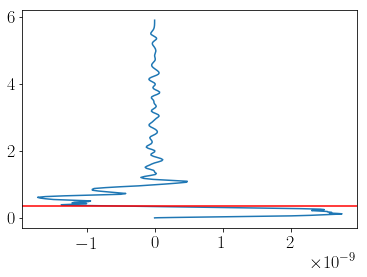

In [515]:
i = 200
plt.plot(vbfv[i,:], z/H[i])
plt.axhline(hn[i]/H[i], color='r')

In [483]:
# Assuming v' ` h/H V_int
h = np.zeros((nt))
C = 80
for i in range(0, nt):
    factor = C**3*Bek[i]**2/(H[i]*0.1**3)*(1e-4/(N**2*tht[0,0,0]))**3

    poly = np.zeros((5,))
    poly[0] = 1
    poly[1] = -factor
    poly[2] = factor
    poly[3] = -3*factor
    poly[4] = factor
    
    if np.isfinite(factor):
        roots = np.roots(poly)*H[i]
        h[i] = roots[-1]
h[h<0] = np.nan


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()


In [484]:
# Try Bachman approach
# Assuming v' ` h/H V_int
def fitH(factor, C):
    nt = factor.size
    h = np.zeros((nt))
    #C = 90
    for i in range(0, nt):
        alpha = C**3*factor #Bek[i]**2/(H[i]*0.1**3)*(1e-4/(N**2*tht[0,0,0]))**3
        p = -3/8*alpha**2 - 3*alpha
        q = 1/8*alpha*((alpha-2)**2 +20)
        Q = ((27*alpha**2 + np.sqrt(729*alpha**4+6912*alpha**3))/2)**(1/3)
        S = 1/2*np.sqrt(2*alpha + 1/4*alpha**2 + 1/3*(Q-12*alpha/Q))
    
        x1 = -alpha/4-S+1/2*np.sqrt(-4*S**2-2*p+q/S)
    
    #h[i] = x1*H[i]
#h[h<0] = np.nan
    return x1

#h = fitH(Bek**2/(H*0.1**3)*(1e-4/(N**2*tht[0,0,0]))**3, 90)*H

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


In [583]:
factor = Bek**2/(H*0.1**3)*(1e-4/(N**2*tht[0,0,0]))**3
ydata = hn/H

#factor = Bek**2/((N**2*tht[0,0,0]/1e-4)**3*(bz[:,0,0])**3*H**4)
mask = np.logical_and((factor>0),np.isfinite(factor+ydata))
mask[0:100] = False
popt, pcov = optimize.curve_fit(fitH, factor[mask], ydata[mask], p0=90)
print(popt[0])

120.70774370708892


In [576]:
factor[mask]

array([], dtype=float64)

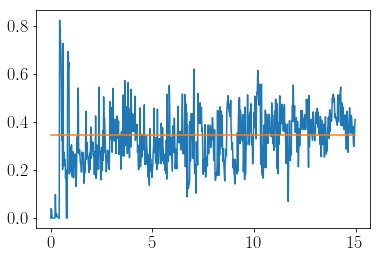

In [588]:
h = fitH(factor, 247)*H
plt.plot(time/86400, hn/H)
plt.plot(time/86400, h/H)

/usr/local/lib/python3.6/site-packages/scipy/optimize/minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


138.6537480774003
119.58515416406284


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


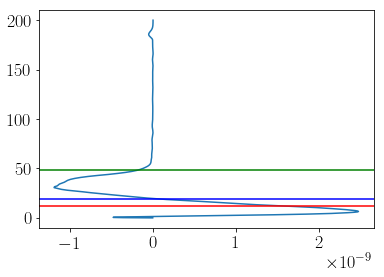

In [587]:
# Try fitting just an averaged profile
ti = range(-100,-1)
hna = np.mean(hn[ti])
Ha = np.mean(H[ti])
Beka = np.mean(Bek[ti])

factor = np.mean(Bek[ti]**2/(H[ti]*0.1**3)*(1e-4/(N**2*tht[0,0,0]))**3)
factor = Beka**2/(Ha*0.1**3)*(1e-4/(N**2*tht[0,0,0]))**3
ydata = np.mean(hn[ti]/H[ti])

popt, pcov = optimize.curve_fit(fitH, factor, ydata, p0=90)
print(popt[0])




c = -(hna/Ha)**(4/3)/(1-hna/Ha)*N**2*tht[0,0,0]*0.1*(-Beka*Ha)**(1/3)/(Beka*1e-4)
print(c)
plt.figure()
plt.plot(np.mean(vbfr[ti,0,:], axis=0), z)
plt.axhline(hna, color='b')
plt.axhline(Ha, color='g')
plt.axhline(fitH(np.array([factor, 0]), 50)[0]*Ha, color='r')

In [553]:
Beka

-4.921320587609208e-09

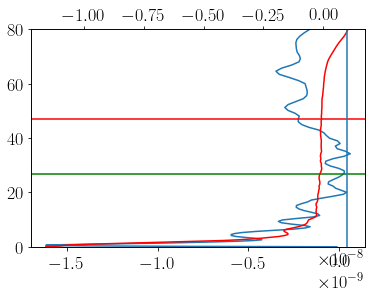

In [487]:
#inds = np.where(np.diff(np.sign(vbfv[i,0,:])) <0)[0]
#z[inds[0]]
i = range(-100,-99)
fig, ax = plt.subplots()
ax.plot(np.mean(vbfr[i,0,:], axis=0), z)
#plt.plot(savgol_filter(np.mean(vbfr[i,0,:], axis=0), 25, 1), z) # window size 51, polynomial order 3

ax.axhline(np.mean(hn[i]), color='r')
ax.axhline(np.mean(h[i]), color='g')
ax.set_ylim((0, 80))

ax2 = plt.twiny()
ax2.plot(np.mean(np.mean(q[i,:,:], axis=0), axis=0), z, color='r')
ax2.set_ylim((0,80))
ax2.axvline(N**2*1e-4)


In [488]:
q = f['tasks']['PV']
q.shape

(480, 1024, 256)

In [564]:
# Calculate alpha and beta parameters (see Taylor and Ferrari 2010)

# TF10 averages in time at depth where q = 0.99Qo
qz = np.gradient(qm, axis=-1)/np.gradient(z)
Qo = 1e-4*N**2
ent = np.zeros((nt,))
zd = np.zeros((nt,))
qft = np.zeros((nt,))
for i in range(0,nt):
    ind = np.where(np.logical_and(qm[i,1:]>0.99*Qo, np.diff((qm[i,:]))>0))[0] +1
    ind = np.where(qm[i,:]>0.99*Qo)[0]

    if ind.size>0:
        zd[i] = z[ind[1]]
        ent[i] = vbfr[i,0,ind[0]] - 1e-4*(np.mean(bz[i,:,ind[0]], axis=0) + N**2)
        qft[i] = 1e-4*qz[i,ind[0]]

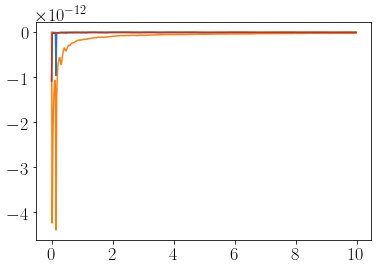

In [490]:
plt.plot(time/86400, -qft)
plt.plot(time/86400, 1e-4*Bek/zd)
plt.plot(time/86400, -1e-4*N**2/zd*1e-4)
plt.plot(time/86400, -1e-4*N**2/zd*1e-4)

#plt.ylim((-5e-15, 0))

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


0.13961866816954044

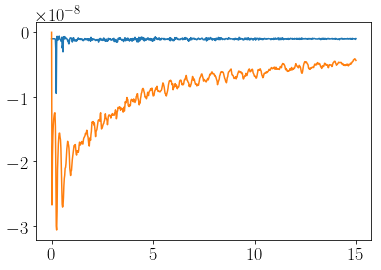

In [589]:
plt.plot(time/86400, ent)
plt.plot(time/86400, Bek)
mask = np.isfinite(ent/Bek)
np.mean(ent[mask]/Bek[mask])

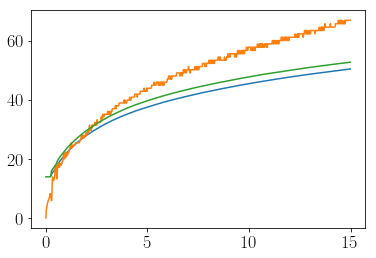

In [590]:

toff = 12*1 # Starting timestep
Ho = 14 # Pick a starting depth (not necessarily starting at t=0, H=0)

#toff = 24
#Ho = 1

#toff = 1
#Ho=1
Ent = 1.03 # Entrainment factor...
H2 = np.zeros((nt, )) 
Htest = np.zeros((nt,)) +Ho 
for i in range(toff, nt):
    H2[i] = H2[i-1]+(2*(Ent)*-Bek[i]/(N**2))*(time[i]-time[i-1])
    #H2[i] = H2[i-1]+(2*(Ent)*(-Bek[i]/(N**2)+1e-4))*(time[i]-time[i-1])
    Htest[i] = Htest[i-1] + (-Ent*Bek[i]/(N**2 * Htest[i-1]) +qft[i]/(1e-4*N**2))*(time[i]-time[i-1])
    #H2[i] = H2[i-1]+(2*(ent[i]/Bek[i]+1)*-Bek[i]/(N**2))*(time[i]-time[i-1])

H = np.sqrt(Ho**2 + H2)
H[0:toff] = np.nan
plt.plot(time/86400, H)
plt.plot(time/86400, zd)
plt.plot(time/86400, Htest)


In [493]:
N**2*np.sin(tht[0,0,0])

9.983341664682812e-07

In [494]:
0.005/(1e-4*1000)

0.049999999999999996

In [495]:
gspr = f['tasks']['GSProtated']
gspr.shape

(480, 1, 256)

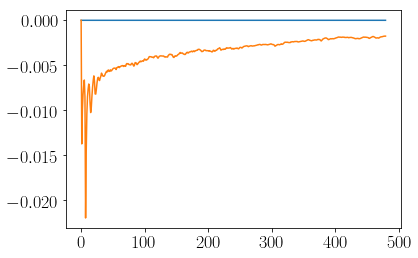

In [496]:
plt.plot(1030*gspr[:,0,0]*1e-4/N**2)
plt.plot(tauy)

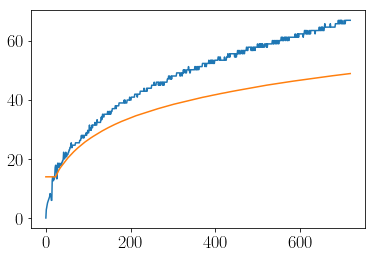

In [566]:
plt.plot(zd)
plt.plot(H)